# 데이터 설명 및 세팅

In [1]:
import numpy as np 
import pandas as pd 
import torch

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Kaggle 에서 아래와 같이 data 를 다운로드 받을 수 있으나, 이는 사용하지 않았음 (API 제공하지 않아서...)
# !pip install kaggle
# cd /content/drive/MyDrive/Analysis
# cp kaggle.json ~/.kaggle/
# !kaggle competitions download -c titanic

In [5]:
cd "/content/drive/MyDrive/Analysis/Pytorch Practice/Breast Cancer Wisconsin (Diagnostic)"

/content/drive/MyDrive/Analysis/Pytorch Practice/Breast Cancer Wisconsin (Diagnostic)


# EDA
- 간략하게만 살펴봄. pytorch data 를 돌려보기만 하는 목적이라 대~충만 살펴봤습니다.

In [7]:
# 데이터가 모두 non-null + float 이다. 그러므로 별도의 전처리 없이, 모델링을 진행할 수 있을 듯 하다.
data = pd.read_csv('./data/data.csv')
data = data.drop(columns = ["Unnamed: 32"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [8]:
data["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [9]:
# 이상한 데이터가 끼어있음;; 
from torch.utils.data import Dataset, DataLoader , random_split

class CustomDataset(Dataset):
    def __init__(self,file_path):
        df = pd.read_csv(file_path)
        df = df.drop(columns = ["Unnamed: 32"])
        df["diagnosis"] = (df["diagnosis"] == "B") * 1
        self.x = torch.tensor(df.drop(columns = ["id","diagnosis"]).values,dtype = torch.float32)
        self.y = torch.tensor(df["diagnosis"].values,dtype = torch.int64)
    def __getitem__(self,idx):
        return self.x[idx,:], self.y[idx]
    def __len__(self) :
        return len(self.y)

In [10]:
dataset = CustomDataset("./data/data.csv")

In [11]:
# Train - Validation - Test Split 은 0.8 / 0.1 / 0.1 
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

In [12]:
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 455
Validation Data Size : 56
Testing Data Size : 58


In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=False)

In [14]:
from torch import nn 
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(30, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [16]:
from torch import optim
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleModel().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

losses = [] 
val_losses = [] 
for epoch in range(100):
    cost = 0.0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output.view_as(output), y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        cost += loss 
    cost = cost / len(train_dataloader)
    losses.append(cost.item())
    eval_cost = 0.0
    model.eval()
    for x, y in validation_dataloader: 
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output.view_as(output), y.unsqueeze(1).float())
        eval_cost += loss 
    eval_cost = eval_cost / len(validation_dataloader)
    val_losses.append(eval_cost.item())
    model.train()

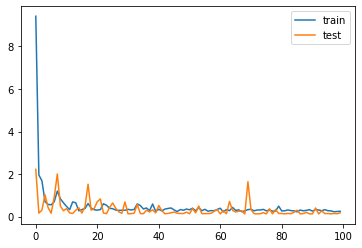

In [20]:
# 엄청나게 빠르게 Converge 한 모습. 이미 overfitting
import matplotlib.pyplot as plt
plt.plot(losses,label = "train")
plt.plot(val_losses,label = "test")
plt.legend() ; 

In [17]:
for x, y in test_dataloader: 
    x = x.to(device)
    y = y.to(device)
    F = nn.Sigmoid()
    # 우리 모델의 경우 output 이 pred 형태가 아니라 아래처럼 해주어야 합니다. 
    output = F(model(x))